In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

df = pd.read_csv("completed_flat_price_2017_2023.csv")

### EDA

In [2]:
# converting remaining_lease to int format:
df_cleaned=df

def three_sd_range(series):
    mean = series.mean()
    sd = series.std()
    low = mean - 3*sd
    high = mean + 3*sd
    
    return (low, high)

lower, upper = three_sd_range(df["resale_price"])
df_cleaned  = df[ (df.resale_price>=lower) & (df.resale_price<=upper)]

df_cleaned=df


def convert_lease_to_int(lease_str):
    parts = lease_str.split()
    years = int(parts[0])
    return years

df_cleaned['remaining_lease_years'] = df['remaining_lease'].apply(convert_lease_to_int)

# encoding flat_type and storey_range to ordinal data:
labelencoder = LabelEncoder()
df_cleaned['flat_type_encoded'] = labelencoder.fit_transform(df_cleaned['flat_type'])
df_cleaned['storey_range_encoded'] = labelencoder.fit_transform(df_cleaned['storey_range'])

# Add a 'year' column to df2 by converting 'month' to datetime and extracting the year
df_cleaned['year'] = pd.to_datetime(df_cleaned['month']).dt.year

# extracting features:
df2= df_cleaned[['flat_type_encoded', 'storey_range_encoded',
                 'floor_area_sqm', 'remaining_lease_years',
                 'resale_price', 'year'
                 ]]

df2

,flat_type_encoded,storey_range_encoded,floor_area_sqm,remaining_lease_years,resale_price,year
0,1,3,44.0,61,232000.0,2017
1,2,0,67.0,60,250000.0,2017
2,2,0,67.0,62,262000.0,2017
3,2,1,68.0,62,265000.0,2017
4,2,0,67.0,62,265000.0,2017
...,...,...,...,...,...,...
146867,4,0,127.0,64,700000.0,2023
146868,4,3,122.0,64,700000.0,2023
146869,5,2,181.0,68,1068000.0,2023
146870,5,3,146.0,64,838000.0,2023


In [3]:
# Splitting into 3 df:
full_dataset = df2
precovid_dataset = df2[(df2['year'] >= 2017) & (df2['year'] <= 2019)]
postcovid_dataset = df2[(df2['year'] >= 2020) ]

### Binning

/var/folders/xz/qc1454j97m3fyrx6gcldlxr40000gn/T/ipykernel_70724/3852828245.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  postcovid_dataset['price_range'] = pd.cut(postcovid_dataset['resale_price'],


price_range
300K-450K    19698
450K-600K    19493
600K-750K     8860
750K<         5285
0-300K        4495
Name: count, dtype: int64

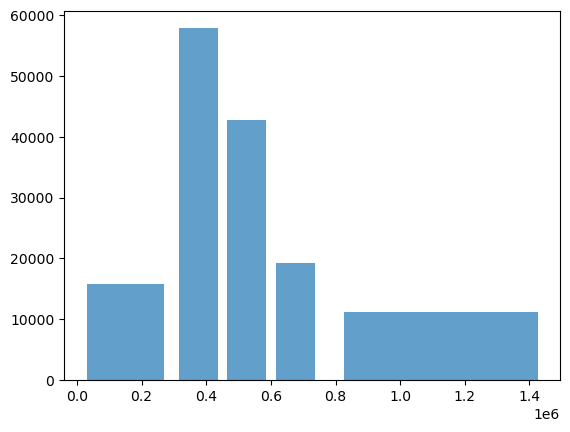

In [4]:

# Binning resale prices into ranges
bins = [0, 300000, 450000, 600000, 750000, 1500000] 
labels = ['0-300K', '300K-450K', '450K-600K', '600K-750K', '750K<']
postcovid_dataset['price_range'] = pd.cut(postcovid_dataset['resale_price'], 
                            bins=bins, labels=labels)

plt.hist(df2['resale_price'], bins=bins, rwidth=0.8, alpha=0.7)

# Select features and target
X = postcovid_dataset[['floor_area_sqm', 'remaining_lease_years', 
        'storey_range_encoded', 'flat_type_encoded']]
y = postcovid_dataset['price_range']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a DecisionTreeClassifier
clf = DecisionTreeClassifier()

# Train the classifier
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

accuracy,report

y_train.value_counts()

### Continuous variables decision tree

Number of nodes in the tree: 63


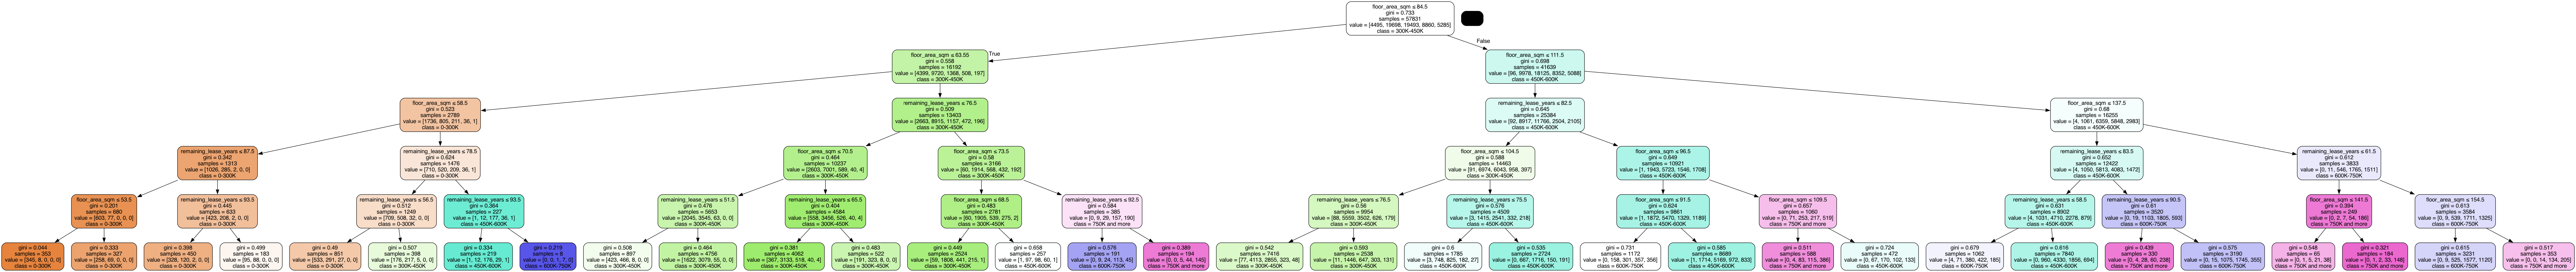

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import pydotplus
from six import StringIO  
from IPython.display import Image


clf = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42) 

feature_cols = ['floor_area_sqm', 'remaining_lease_years']
X_train_reduced = X_train[feature_cols]

clf.fit(X_train_reduced, y_train)
print('Number of nodes in the tree:', clf.tree_.node_count)

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, 
                feature_names=feature_cols,  
                class_names=['0-300K', '300K-450K', '450K-600K', '600K-750K', '750K and more'],
                filled=True, rounded=True,  
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

Number of nodes in the tree: 15


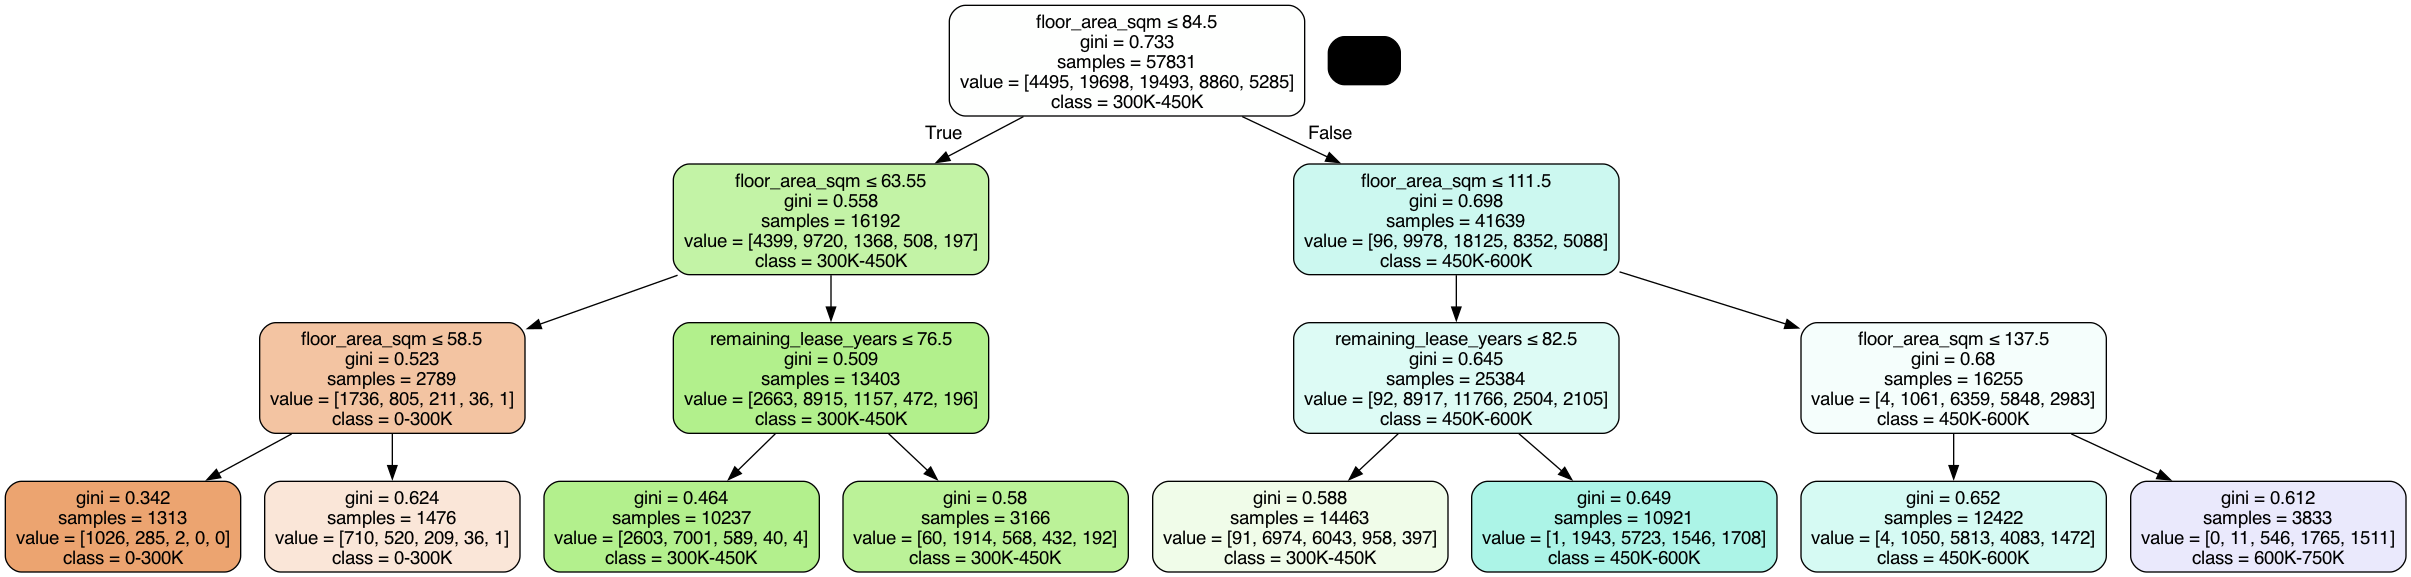

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import pydotplus
from six import StringIO  
from IPython.display import Image


clf = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42) 

feature_cols = ['floor_area_sqm', 'remaining_lease_years']
X_train_reduced = X_train[feature_cols]

clf.fit(X_train_reduced, y_train)
print('Number of nodes in the tree:', clf.tree_.node_count)

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, 
                feature_names=feature_cols,  
                class_names=['0-300K', '300K-450K', '450K-600K', '600K-750K', '750K<'],
                filled=True, rounded=True,  
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predict the labels of the test set
y_pred = clf.predict(X_test[feature_cols])

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=[str(x) for x in clf.classes_])
print("Classification Report:")
print(report)

# Generate and display a confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Model Accuracy: 0.53


/Users/poyry/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/poyry/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score   support

      0-300K       0.59      0.37      0.45      1828
   300K-450K       0.56      0.81      0.66      8403
   450K-600K       0.50      0.59      0.54      8466
   600K-750K       0.47      0.20      0.28      3853
       750K<       0.00      0.00      0.00      2235

    accuracy                           0.53     24785
   macro avg       0.42      0.39      0.39     24785
weighted avg       0.48      0.53      0.48     24785

Confusion Matrix:
[[ 673 1155    0    0    0]
 [ 352 6771 1276    4    0]
 [  98 3181 4969  218    0]
 [  17  671 2411  754    0]
 [   0  274 1316  645    0]]


/Users/poyry/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### CatBoost on decision tree (continuous variables)

In [8]:
# catboost on numerical variables:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'X' and 'y' are your features and target variable from your dataset
# And you have already preprocessed and split your data into training and test sets.

# Initialize CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=1000, 
    depth=3, 
    learning_rate=0.01, 
    loss_function='MultiClass',  # Use 'Logloss' for binary classification
    verbose=200,  # To limit the amount of output during training
    random_seed=42
)

# Fit the model
catboost_model.fit(X_train_reduced, y_train)

# Make predictions
y_pred = catboost_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy.round(2)}")

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=['0-300K', '300K-450K', '450K-600K', '600K-750K', '750K+'])
print("Classification Report:")
print(report)

0:	learn: 1.6000947	total: 62.6ms	remaining: 1m 2s
200:	learn: 1.0784828	total: 800ms	remaining: 3.18s
400:	learn: 1.0143147	total: 1.52s	remaining: 2.28s
600:	learn: 0.9915907	total: 2.3s	remaining: 1.52s
800:	learn: 0.9764857	total: 3.02s	remaining: 750ms
999:	learn: 0.9665218	total: 3.81s	remaining: 0us
Model Accuracy: 0.58
Classification Report:
              precision    recall  f1-score   support

      0-300K       0.66      0.36      0.46      1828
   300K-450K       0.61      0.75      0.67      8403
   450K-600K       0.56      0.65      0.60      8466
   600K-750K       0.52      0.38      0.44      3853
       750K+       0.66      0.20      0.31      2235

    accuracy                           0.58     24785
   macro avg       0.60      0.47      0.50     24785
weighted avg       0.59      0.58      0.56     24785



### Encoded variables decision tree

Number of nodes in the tree: 15


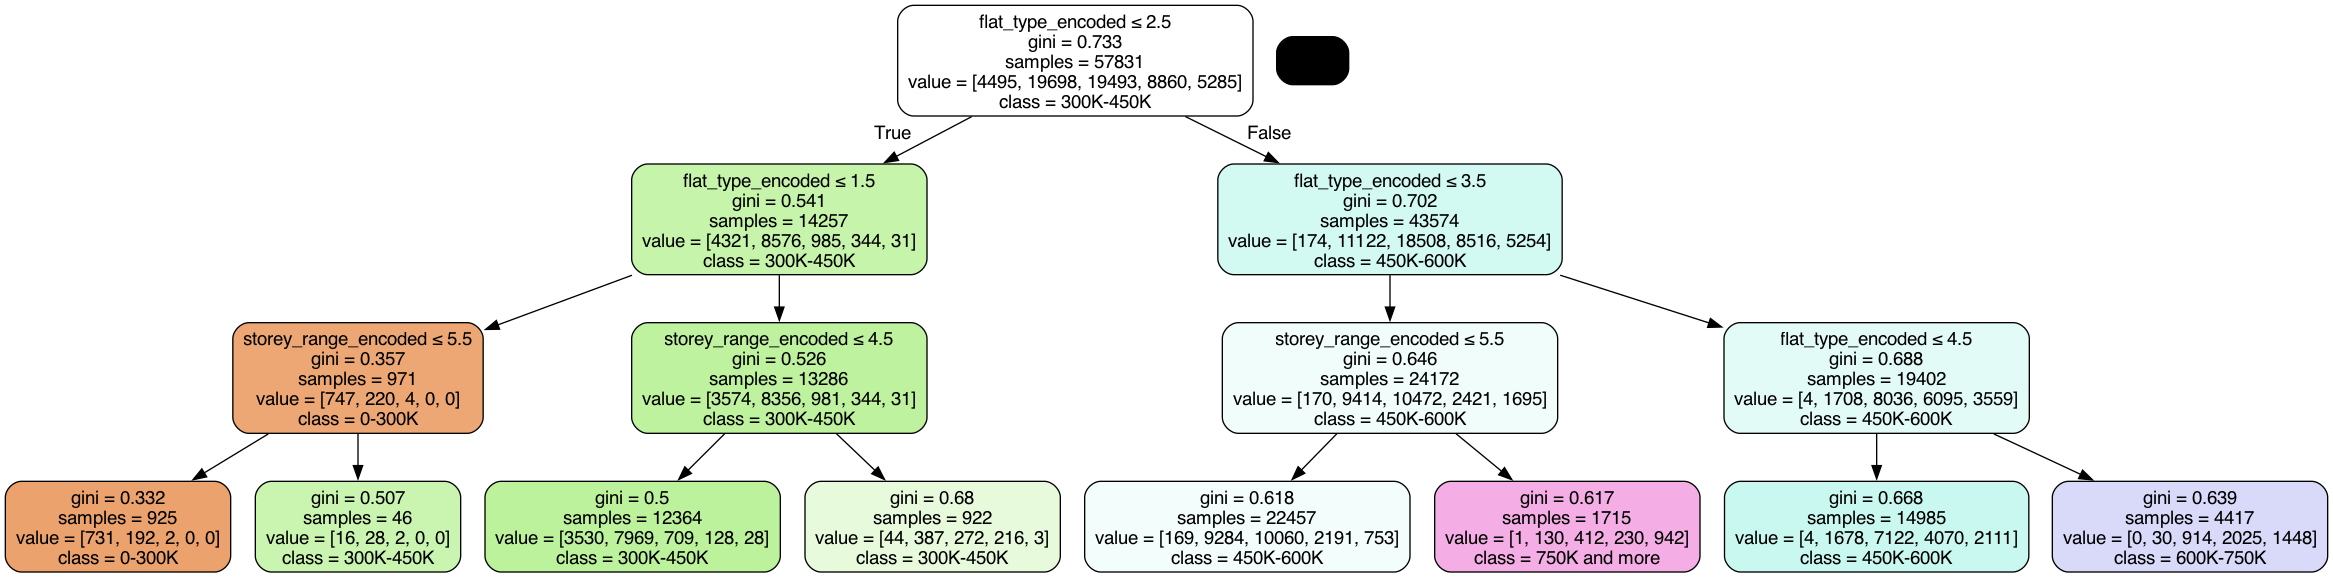

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import pydotplus
from six import StringIO  
from IPython.display import Image


clf = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42) 

feature_cols = ['flat_type_encoded', 'storey_range_encoded']
X_train_reduced = X_train[feature_cols]

clf.fit(X_train_reduced, y_train)
print('Number of nodes in the tree:', clf.tree_.node_count)

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, 
                feature_names=feature_cols,  
                class_names=['0-300K', '300K-450K', '450K-600K', '600K-750K', '750K and more'],
                filled=True, rounded=True,  
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predict the labels of the test set
y_pred = clf.predict(X_test[feature_cols])

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=[str(x) for x in clf.classes_])
print("Classification Report:")
print(report)

# Generate and display a confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Model Accuracy: 0.51
Classification Report:
              precision    recall  f1-score   support

      0-300K       0.75      0.16      0.27      1828
   300K-450K       0.63      0.43      0.51      8403
   450K-600K       0.46      0.88      0.61      8466
   600K-750K       0.47      0.23      0.31      3853
       750K<       0.52      0.17      0.26      2235

    accuracy                           0.51     24785
   macro avg       0.57      0.37      0.39     24785
weighted avg       0.55      0.51      0.47     24785

Confusion Matrix:
[[ 295 1469   64    0    0]
 [  96 3592 4675    3   37]
 [   2  446 7440  376  202]
 [   0  149 2712  876  116]
 [   0   15 1223  610  387]]


#### CatBoost on decision tree (encoded variables)

In [11]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize CatBoostClassifier
catboost_model = CatBoostClassifier(
    iterations=1000, 
    depth=3, 
    learning_rate=0.01, 
    loss_function='MultiClass',  
    verbose=200, 
    random_seed=42
)

# Fit the model
catboost_model.fit(X_train_reduced, y_train)
# Make predictions
y_pred = catboost_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy.round(2)}")

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=['0-300K', '300K-450K', 
                                                            '450K-600K', '600K-750K', '750K+'])
print("Classification Report:")
print(report)

0:	learn: 1.6002953	total: 7.32ms	remaining: 7.32s
200:	learn: 1.1002438	total: 936ms	remaining: 3.72s
400:	learn: 1.0466921	total: 1.82s	remaining: 2.72s
600:	learn: 1.0355682	total: 2.65s	remaining: 1.76s
800:	learn: 1.0324999	total: 3.48s	remaining: 864ms
999:	learn: 1.0313078	total: 4.39s	remaining: 0us
Model Accuracy: 0.54
Classification Report:
              precision    recall  f1-score   support

      0-300K       0.75      0.16      0.27      1828
   300K-450K       0.59      0.68      0.63      8403
   450K-600K       0.50      0.70      0.58      8466
   600K-750K       0.48      0.23      0.32      3853
       750K+       0.59      0.28      0.38      2235

    accuracy                           0.54     24785
   macro avg       0.58      0.41      0.44     24785
weighted avg       0.56      0.54      0.52     24785



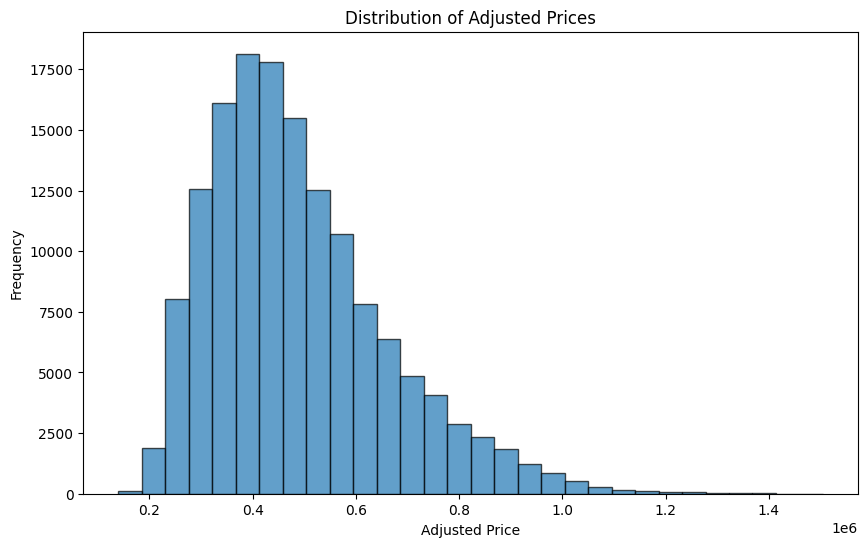

/var/folders/dh/rl06mgxn293dn9_qw9161yh00000gn/T/ipykernel_11450/3132215598.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['price_range'] = pd.cut(df2['adjusted_price'], bins=quantile_edges, labels=labels, include_lowest=True)


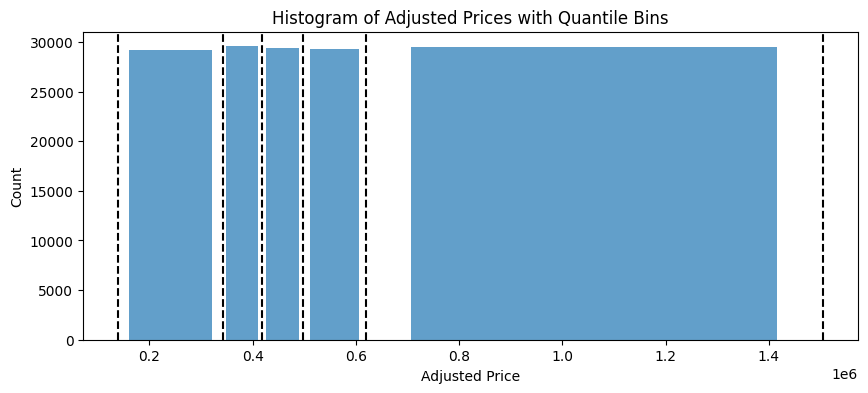

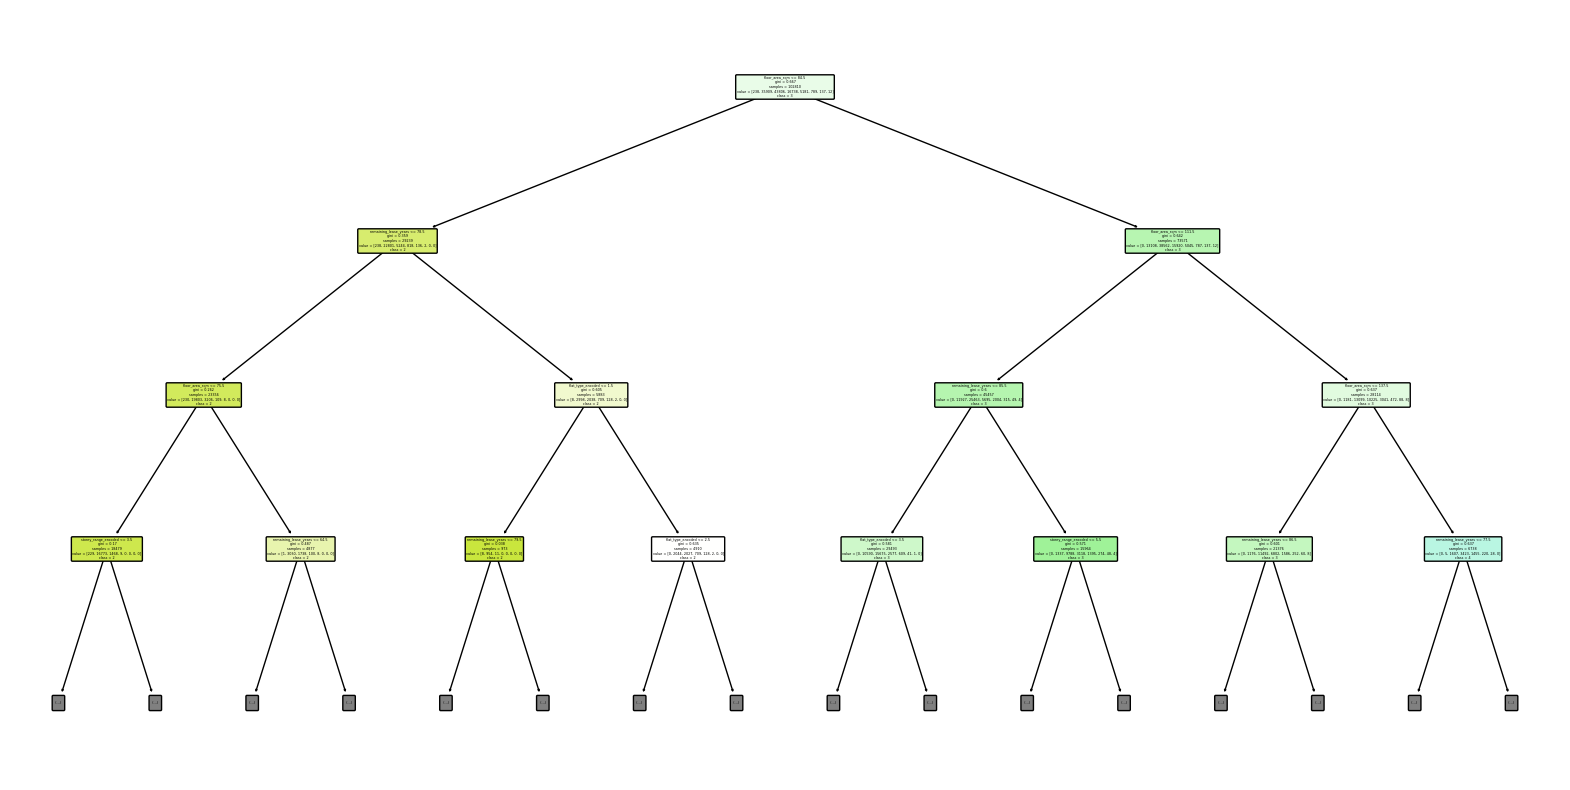

In [52]:
import numpy as np

# Visualize the distribution of adjusted_price
plt.figure(figsize=(10, 6))
plt.hist(df2['adjusted_price'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Adjusted Prices')
plt.xlabel('Adjusted Price')
plt.ylabel('Frequency')
plt.show()

# Determine appropriate bin edges based on the distribution
# For example, using quantiles
quantile_edges = df2['adjusted_price'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).values
labels = [1, 2, 3, 4, 5]
df2['price_range'] = pd.cut(df2['adjusted_price'], bins=quantile_edges, labels=labels, include_lowest=True)

# Assuming you have already split your dataset into X and y, and trained the classifier 'clf'

# Plot the bins based on quantiles on the histogram
plt.figure(figsize=(10, 4))
for edge in quantile_edges:
    plt.axvline(x=edge, color='k', linestyle='--')
plt.hist(df2['adjusted_price'], bins=quantile_edges, rwidth=0.8, alpha=0.7)
plt.title('Histogram of Adjusted Prices with Quantile Bins')
plt.xlabel('Adjusted Price')
plt.ylabel('Count')
plt.show()

# Convert labels to string type to ensure compatibility with tree.plot_tree
labels_str = [str(label) for label in labels]

# Plot the decision tree with a limited depth for readability
plt.figure(figsize=(20, 10))
tree.plot_tree(clf, feature_names=X.columns, class_names=labels_str, filled=True, rounded=True, max_depth=3)
plt.show()


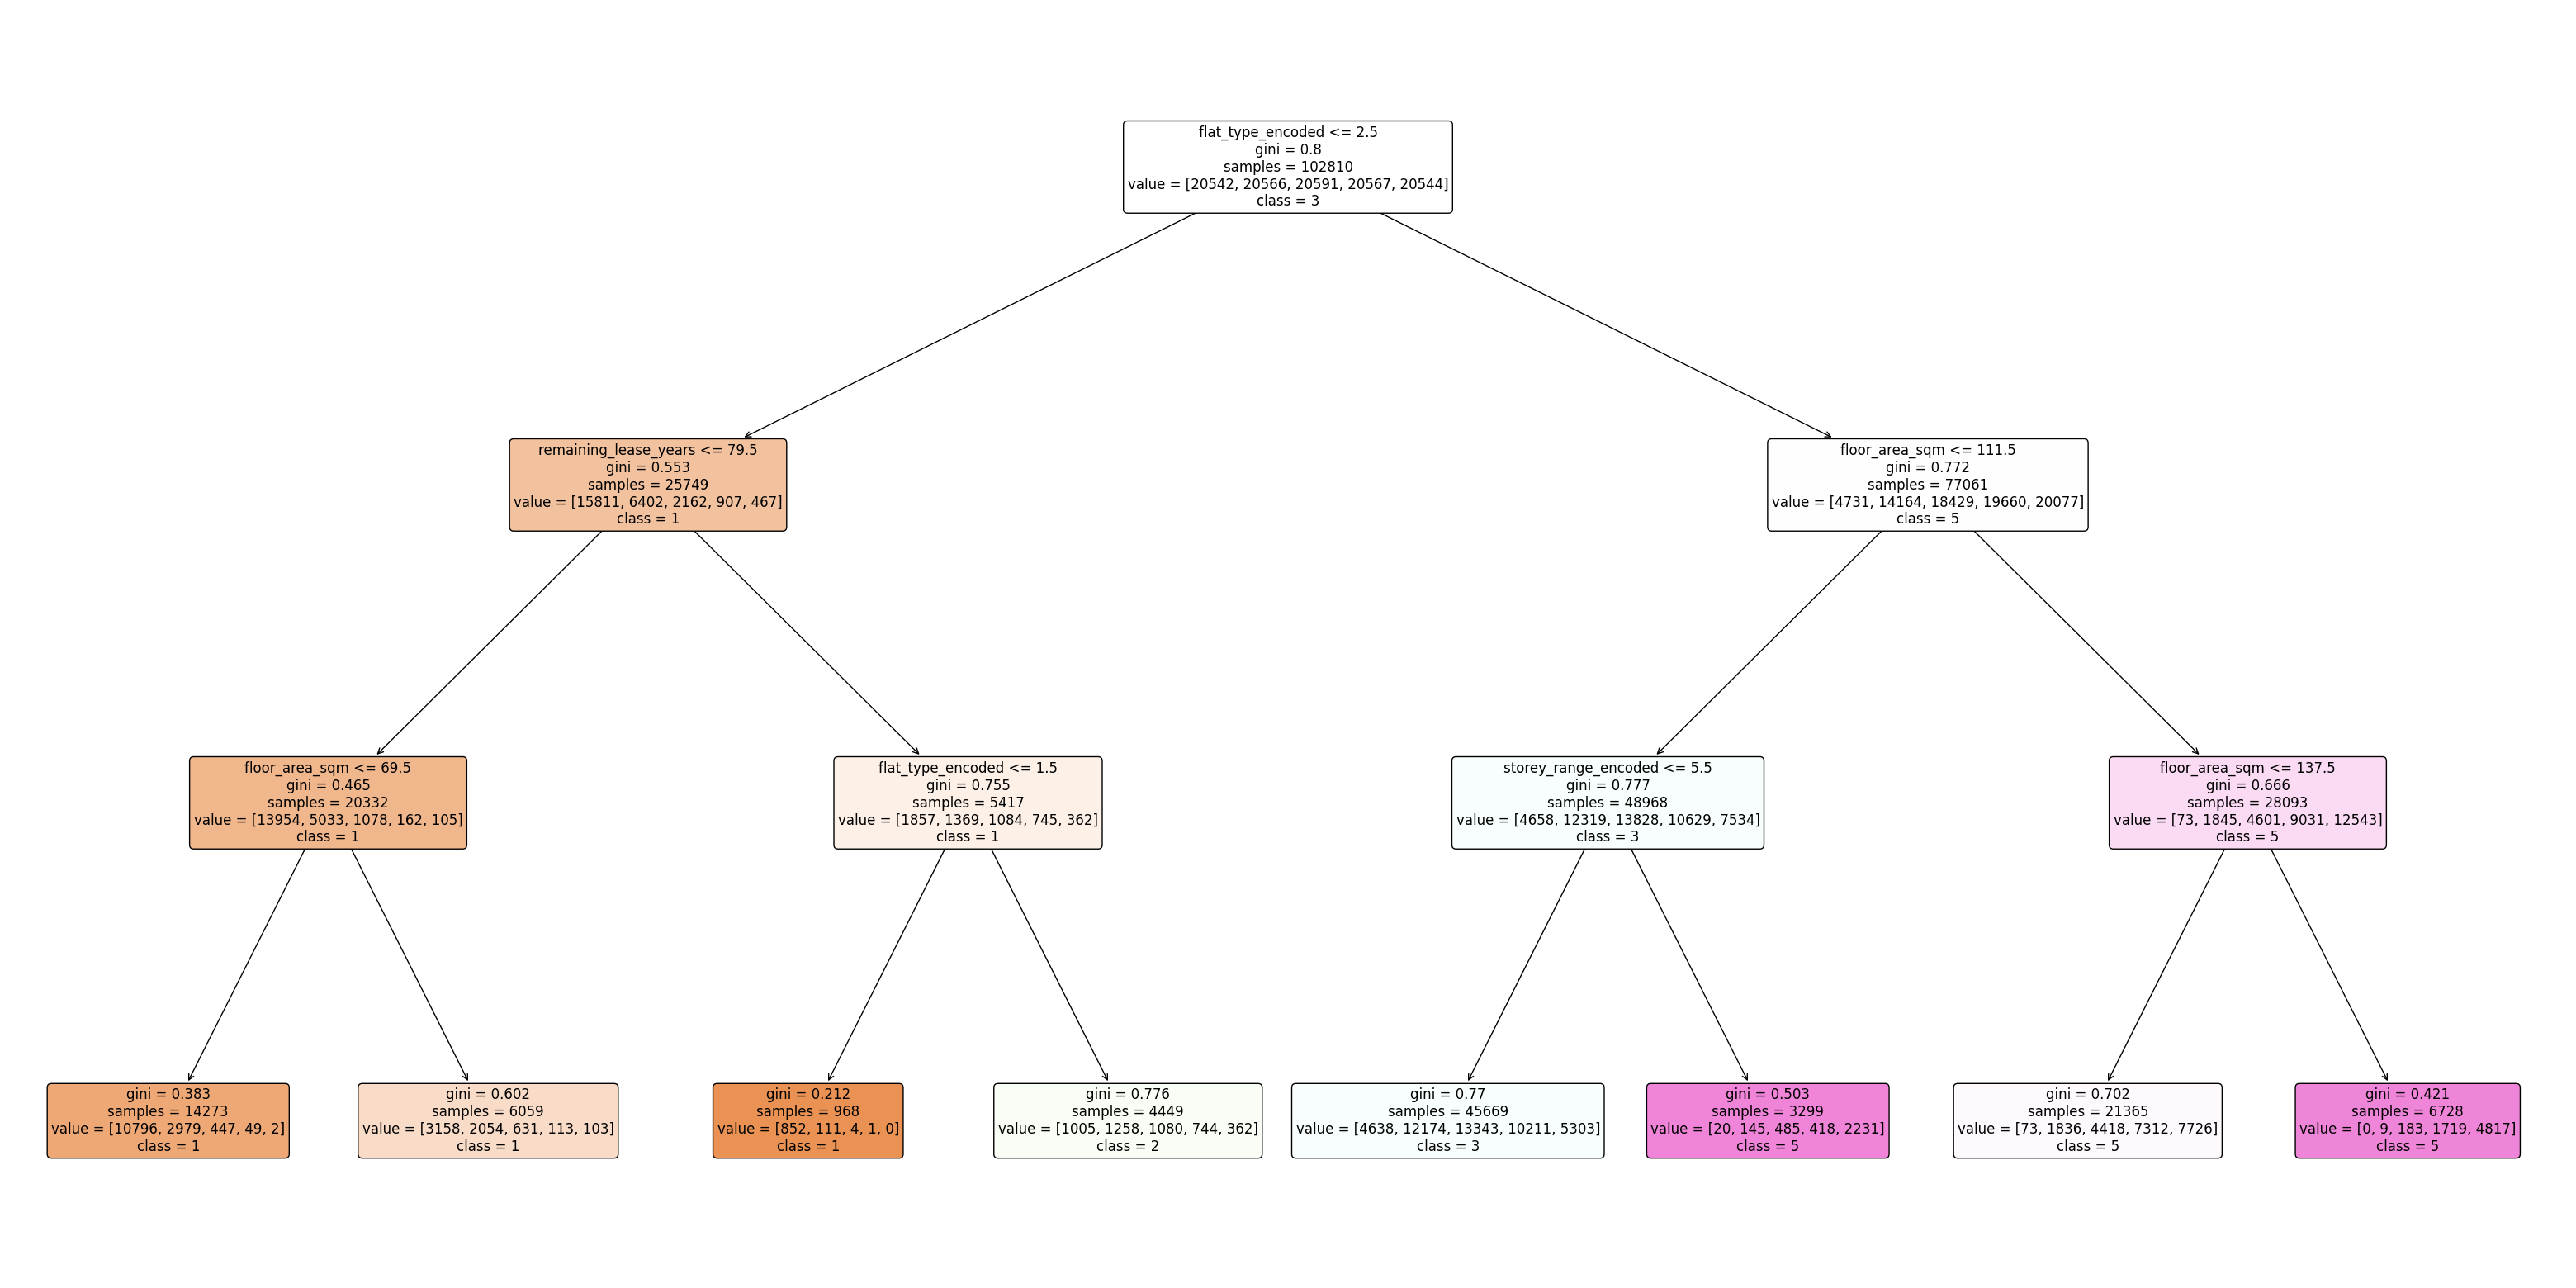

In [55]:
plt.figure(figsize=(40, 20))  # Set an even larger figure size if needed

# Plot the decision tree
decision_tree = tree.plot_tree(
    clf,
    feature_names=X.columns,
    class_names=labels_str,
    filled=True,
    rounded=True,
    fontsize=12  # Try increasing this value
)

# Increase the size of the leaf nodes
for o in decision_tree:
    if 'leaf' in o.get_text():
        o.set_size(20)

plt.show()


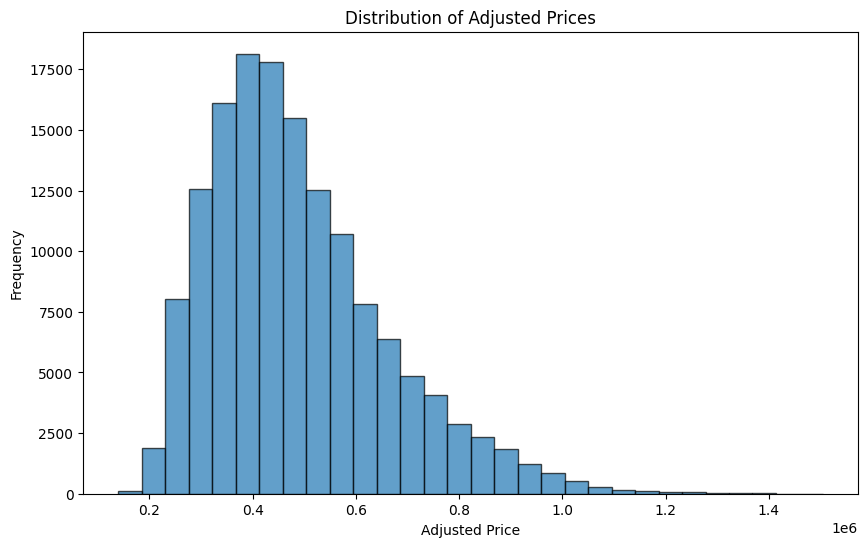

/var/folders/dh/rl06mgxn293dn9_qw9161yh00000gn/T/ipykernel_11450/3080901174.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['price_range'] = pd.cut(df2['adjusted_price'], bins=quantile_edges, labels=labels, include_lowest=True)


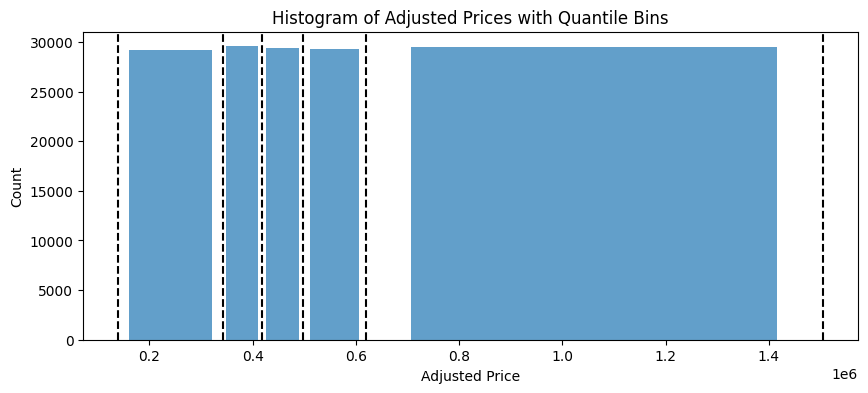

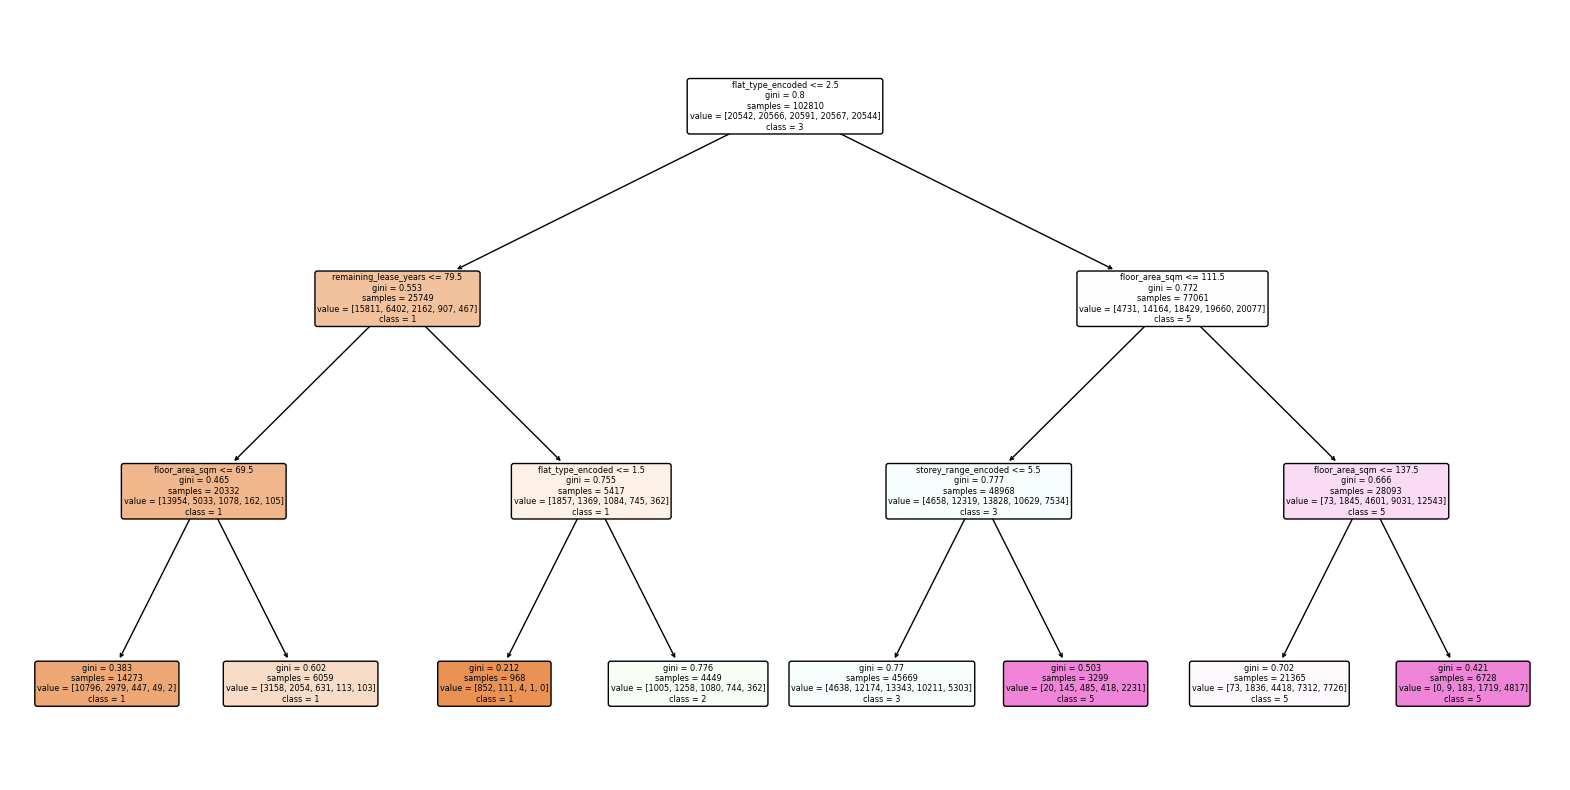

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assuming `df2` is already loaded in the environment with the appropriate structure.

# Visualize the distribution of adjusted_price
plt.figure(figsize=(10, 6))
plt.hist(df2['adjusted_price'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Adjusted Prices')
plt.xlabel('Adjusted Price')
plt.ylabel('Frequency')
plt.show()

# Determine appropriate bin edges based on the distribution
# For example, using quantiles
quantile_edges = df2['adjusted_price'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).values
labels = ['1', '2', '3', '4', '5']  # Convert labels to string type directly
df2['price_range'] = pd.cut(df2['adjusted_price'], bins=quantile_edges, labels=labels, include_lowest=True)

# Split the dataset into features and target
X = df2[['flat_type_encoded', 'storey_range_encoded', 'floor_area_sqm', 'remaining_lease_years']]
y = df2['price_range']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train a DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=3)  # Limiting the depth of the tree
clf.fit(X_train, y_train)

# Plot the bins based on quantiles on the histogram
plt.figure(figsize=(10, 4))
for edge in quantile_edges:
    plt.axvline(x=edge, color='k', linestyle='--')
plt.hist(df2['adjusted_price'], bins=quantile_edges, rwidth=0.8, alpha=0.7)
plt.title('Histogram of Adjusted Prices with Quantile Bins')
plt.xlabel('Adjusted Price')
plt.ylabel('Count')
plt.show()

# Plot the decision tree with a limited depth for readability
plt.figure(figsize=(20, 10))
tree.plot_tree(clf, feature_names=X.columns, class_names=labels, filled=True, rounded=True)
plt.show()
